<>:83: SyntaxWarning: invalid escape sequence '\i'
<>:83: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_5632/1606737956.py:83: SyntaxWarning: invalid escape sequence '\i'
  """


[Ep 500/3000] CriticLoss=271.9671, ActorLoss=0.0781
[Ep 1000/3000] CriticLoss=76.5708, ActorLoss=1.4470
[Ep 1500/3000] CriticLoss=151.3871, ActorLoss=1.0655
[Ep 2000/3000] CriticLoss=15.7637, ActorLoss=0.3346
[Ep 2500/3000] CriticLoss=22.1093, ActorLoss=0.7299
[Ep 3000/3000] CriticLoss=15.3364, ActorLoss=0.3430


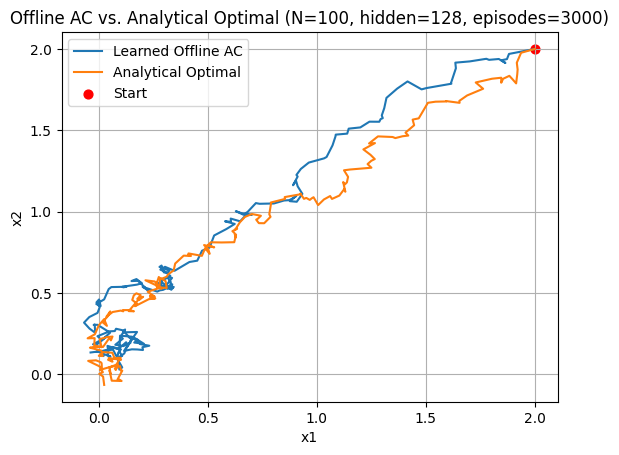

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.integrate import quad

###############################################################################
# 1. 连续时间软 LQR 环境(保留你的部分): SoftLQR
###############################################################################
class SoftLQR:
    """
    与原先相同：包含 solve_riccati_ode, value_function, simulate_trajectory 等
    """

    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        H, M, C, D, R: 定义LQR问题的矩阵(2x2)
        sigma: 噪声(2x2)
        T: 终止时间
        N: 用于离散time_grid(仅供内部,不一定用于仿真)
        tau: 熵正则系数
        gamma: 策略先验分布方差系数
        """
        self.H = H.clone().float()
        self.M = M.clone().float()
        self.C = C.clone().float()
        self.D = D.clone().float()
        self.R = R.clone().float()
        self.sigma = sigma.clone().float()

        self.T = float(T)
        self.N = int(N)
        self.tau = float(tau)
        self.gamma = float(gamma)

        # 时间网格
        self.time_grid = torch.linspace(0.0, self.T, self.N+1)
        # 求解修正后的 Riccati
        self.S_values = self.solve_riccati_ode()

    def riccati_ode(self, t, S_flat):
        """
        dS/dt = S M (D_eff^{-1}) M^T S - H^T S - S H - C
        其中 D_eff = D + tau/(2 gamma^2) I
        """
        S_mat = torch.tensor(S_flat, dtype=torch.float32).view(2,2)
        D_eff = self.D + (self.tau/(2.0*self.gamma**2)) * torch.eye(2)
        inv_D_eff = torch.linalg.inv(D_eff)

        deriv = (S_mat @ self.M @ inv_D_eff @ self.M.T @ S_mat
                 - self.H.T @ S_mat - S_mat @ self.H - self.C)
        return deriv.flatten().numpy()

    def solve_riccati_ode(self):
        # 终端条件 S(T) = R
        S_terminal = self.R.flatten().numpy()
        t_span = (self.T, 0.0)
        t_eval_reversed = np.linspace(self.T, 0.0, self.N+1)

        sol = solve_ivp(self.riccati_ode, t_span, S_terminal, t_eval=t_eval_reversed,
                        atol=1e-10, rtol=1e-10)
        S_matrices = sol.y.T[::-1]  # shape (N+1,4)

        out_dict = {}
        for i, t_val in enumerate(self.time_grid):
            out_dict[float(t_val.item())] = torch.tensor(S_matrices[i], dtype=torch.float32).view(2,2)
        return out_dict

    def get_S_t(self, t):
        # 找最近的网格点
        idx = torch.argmin(torch.abs(self.time_grid - t))
        t_nearest = float(self.time_grid[idx].item())
        return self.S_values[t_nearest]

    def value_function(self, t, x):
        """
        解析价值(不含熵常数):
        v(t, x) = x^T S(t) x + \int_t^T trace(sigma sigma^T S(r)) dr
        """
        S_t = self.get_S_t(t)
        val = x @ S_t @ x

        def integrand(r_float):
            S_r = self.get_S_t(torch.tensor(r_float, dtype=torch.float32))
            return float(torch.trace(self.sigma @ self.sigma.T @ S_r).item())

        integral_val, _ = quad(integrand, t, self.T)
        val += integral_val
        return val

    def simulate_trajectory(self, x0, n_steps=None, dt=None, use_optimal=True):
        """
        显式欧拉仿真(仅用于最终可视化对比).
        if use_optimal=True => 用解析最优 soft 策略
        """
        if n_steps is None:
            n_steps = self.N
        if dt is None:
            dt = self.T / n_steps

        x_current = x0.clone().float()
        traj = [x_current.numpy().copy()]

        for step in range(n_steps):
            t_current = step * dt
            if t_current > self.T:
                t_current = self.T

            if use_optimal:
                # 解析最优分布
                D_eff = self.D + (self.tau/(2.0*self.gamma**2))*torch.eye(2)
                inv_D_eff = torch.linalg.inv(D_eff)
                S_t = self.get_S_t(torch.tensor(t_current))
                mean = -inv_D_eff @ self.M.T @ S_t @ x_current
                cov = self.tau * D_eff
                dist_a = MultivariateNormal(mean, cov)
                a_sample = dist_a.sample()
            else:
                a_sample = torch.zeros(2)

            drift = self.H @ x_current + self.M @ a_sample
            noise = self.sigma @ torch.randn(2)
            x_next = x_current + drift*dt + noise*np.sqrt(dt)

            x_current = x_next
            traj.append(x_current.numpy().copy())

        return np.array(traj)


###############################################################################
# 2. 策略网络(Actor) + 价值网络(Critic)
###############################################################################
class PolicyNet(nn.Module):
    """
    输入 (t, x1, x2) -> 输出 a ~ N(mean, cov)
    采用下三角 L => cov = L L^T
    隐藏层加大,利于表达能力
    """
    def __init__(self, hidden_size=128):
        super().__init__()
        self.l1 = nn.Linear(3, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.out_mean = nn.Linear(hidden_size, 2)
        self.out_L = nn.Linear(hidden_size, 3)
        self.register_buffer("tril_idx", torch.tril_indices(2,2))

    def forward(self, t, x):
        """
        t: (batch,1)  x: (batch,2)
        => (batch,3)
        """
        inp = torch.cat([t, x], dim=1)
        h = torch.relu(self.l1(inp))
        h = torch.relu(self.l2(h))
        mean = self.out_mean(h)    # (batch,2)
        L_raw = self.out_L(h)      # (batch,3)
        batch_size = mean.size(0)
        L_list = []
        for i in range(batch_size):
            L = torch.zeros(2,2, device=inp.device)
            L[self.tril_idx[0], self.tril_idx[1]] = L_raw[i]
            L_list.append(L)
        L_ten = torch.stack(L_list, dim=0)  # (batch,2,2)
        cov = torch.bmm(L_ten, L_ten.transpose(1,2)) + 1e-4*torch.eye(2, device=inp.device).unsqueeze(0)
        return mean, cov

class ValueNet(nn.Module):
    """
    输入 (t, x1, x2) -> 输出 V(t,x)
    """
    def __init__(self, hidden_size=128):
        super().__init__()
        self.l1 = nn.Linear(3, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size,1)

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        h = torch.relu(self.l1(inp))
        h = torch.relu(self.l2(h))
        v = self.out(h).squeeze(-1)
        return v


###############################################################################
# 3. Offline Actor-Critic: 整条轨迹 -> (14),(15) 批量更新
###############################################################################
class OfflineActorCritic:
    def __init__(self, env: SoftLQR, policy_net: PolicyNet, value_net: ValueNet,
                 lr_actor=5e-4, lr_critic=5e-4, device="cpu", episodes=3000):
        self.env = env
        self.policy_net = policy_net
        self.value_net = value_net
        self.episodes = episodes
        self.device = device

        self.policy_net.to(device)
        self.value_net.to(device)

        self.actor_opt = optim.Adam(self.policy_net.parameters(), lr=lr_actor)
        self.critic_opt = optim.Adam(self.value_net.parameters(), lr=lr_critic)

        self.tau = env.tau
        self.dt = env.T/env.N   # dt

    def sample_full_trajectory(self, x0=None):
        """
        一次Episode: t=0..T, 共N步(与env.N一致)
        记录 { t_n, x_n, a_n, cost_n, logp_n } + x_N 用于 terminal cost
        其中 cost_n = x_n^T C x_n + a_n^T D a_n (不含 tau*logp,后面再加)
        """
        # 初始
        x_current = x0 if x0 is not None else torch.randn(2, device=self.device)*2.0
        x_current = x_current.clone().float()
        t_current = 0.0

        t_list = []
        x_list = []
        a_list = []
        cost_list = []
        logp_list = []

        for n in range(self.env.N):
            # forward
            t_ten = torch.tensor([[t_current]], dtype=torch.float32, device=self.device)
            x_ten = x_current.unsqueeze(0)

            mean_b, cov_b = self.policy_net(t_ten, x_ten)
            dist = MultivariateNormal(mean_b[0], cov_b[0])
            a_samp = dist.sample()
            logp_samp = dist.log_prob(a_samp)

            # cost
            cost_quad = (x_current @ self.env.C @ x_current) + (a_samp @ self.env.D @ a_samp)

            # 存储
            t_list.append(t_current)
            x_list.append(x_current.detach().clone())
            a_list.append(a_samp.detach().clone())
            cost_list.append(cost_quad.detach().clone())
            logp_list.append(logp_samp.detach().clone())

            # 显式Euler
            drift = self.env.H @ x_current + self.env.M @ a_samp
            noise = self.env.sigma @ torch.randn(2, device=self.device)
            x_next = x_current + drift*self.dt + noise*np.sqrt(self.dt)

            x_current = x_next
            t_current += self.dt
            if t_current> self.env.T - 1e-14:
                t_current = self.env.T

        xN = x_current
        return t_list, x_list, a_list, cost_list, logp_list, xN

    def critic_loss(self, t_list, x_list, cost_list, logp_list, xN):
        """
        对应(15):
        L(eta) = sum_{n=0}^{N-1}[v(t_n,x_n) - ( sum_{k=n}^{N-1}[cost_k + tau logp_k]*dt - g_{t_N} )]^2
        """
        N = len(t_list)
        t_tensor = torch.tensor(t_list, device=self.device).float().view(-1,1)
        x_tensor = torch.stack(x_list).to(self.device)
        v_n = self.value_net(t_tensor, x_tensor) # (N,)

        cost_ten = torch.stack(cost_list).to(self.device)
        logp_ten = torch.stack(logp_list).to(self.device)
        stage_val = cost_ten + self.tau*logp_ten  # (N,)
        prefix_sum = torch.cumsum(stage_val, dim=0)*self.dt
        final_val = prefix_sum[-1]  # sum_{k=0..N-1}

        # 终端
        g_T = xN @ self.env.R @ xN

        # target_n = [ sum_{k=n}^{N-1} stage_val[k]*dt ] - g_T
        #          = prefix_sum[N] - prefix_sum[n] - g_T
        targets = []
        for n in range(N):
            t_n = (final_val - prefix_sum[n]) - g_T
            targets.append(t_n)
        targets = torch.stack(targets, dim=0) # (N,)

        td = v_n - targets.detach()
        loss_c = 0.5*(td**2).mean()
        return loss_c

    def actor_loss(self, t_list, x_list, a_list, cost_list, logp_list, xN):
        """
        对应(14):
        G^theta = sum_n [ grad log p^theta(a_n) * (Delta_v_n + [ cost_n + tau logp_n]*dt ) ]
        => loss_a = - G^theta
        其中 Delta_v_n = v(t_{n+1}, x_{n+1}) - v(t_n, x_n)
        """
        N = len(t_list)
        t_tensor = torch.tensor(t_list, device=self.device).float().view(-1,1)
        x_tensor = torch.stack(x_list).to(self.device)

        # v_n
        v_n = self.value_net(t_tensor, x_tensor)

        # v_{n+1}:
        t_np1 = t_tensor + self.dt
        x_np1_list = []
        for i in range(N-1):
            x_np1_list.append(x_tensor[i+1])
        # 最后:
        x_np1_list.append(xN.view(1,2)[0])  # 替换成终端
        x_np1_ten = torch.stack(x_np1_list, dim=0)
        v_np1 = self.value_net(t_np1, x_np1_ten)

        cost_ten = torch.stack(cost_list).to(self.device)
        logp_ten = torch.stack(logp_list).to(self.device)
        stage_ten = cost_ten + self.env.tau*logp_ten # (N,)

        # 重新 forward 算 logp 以带梯度
        mean_b, cov_b = self._actor_forward_batch(t_tensor, x_tensor)
        dist_list = [MultivariateNormal(mean_b[i], cov_b[i]) for i in range(N)]

        inside_list = []
        logp_list2 = []
        for n in range(N):
            delta_v = (v_np1[n] - v_n[n]).detach()  # 不回传 Critic梯度
            inside = delta_v + stage_ten[n]*self.dt
            inside_list.append(inside)
            logp_ = dist_list[n].log_prob(a_list[n].to(self.device))
            logp_list2.append(logp_)

        inside_ten = torch.stack(inside_list, dim=0)
        logp_ten2 = torch.stack(logp_list2, dim=0)
        # actorLoss = - sum_n [ inside_ten[n]* logp_ten2[n] ]
        loss_a = - (inside_ten * logp_ten2).mean()
        return loss_a

    def _actor_forward_batch(self, t_tensor, x_tensor):
        # batch 版 forward
        inp = torch.cat([t_tensor, x_tensor], dim=1)
        h = torch.relu(self.policy_net.l1(inp))
        h = torch.relu(self.policy_net.l2(h))
        mean_b = self.policy_net.out_mean(h)
        L_raw = self.policy_net.out_L(h)
        batch_size = mean_b.size(0)
        cov_list = []
        for i in range(batch_size):
            L = torch.zeros(2,2, device=inp.device)
            L[self.policy_net.tril_idx[0], self.policy_net.tril_idx[1]] = L_raw[i]
            cov_list.append(L @ L.T + 1e-4*torch.eye(2, device=inp.device))
        cov_b = torch.stack(cov_list, dim=0)
        return mean_b, cov_b

    def train(self):
        for ep in range(self.episodes):
            # 1) 采样一条轨迹
            t_list, x_list, a_list, cost_list, logp_list, xN = self.sample_full_trajectory()

            # 2) Critic更新
            self.critic_opt.zero_grad()
            loss_c = self.critic_loss(t_list, x_list, cost_list, logp_list, xN)
            loss_c.backward()
            self.critic_opt.step()

            # 3) Actor更新
            self.actor_opt.zero_grad()
            loss_a = self.actor_loss(t_list, x_list, a_list, cost_list, logp_list, xN)
            loss_a.backward()
            self.actor_opt.step()

            if (ep+1)%500 == 0:
                print(f"[Ep {ep+1}/{self.episodes}] CriticLoss={loss_c.item():.4f}, ActorLoss={loss_a.item():.4f}")


###############################################################################
# 4. 主函数：整合 + 调参
###############################################################################
def main():
    torch.manual_seed(42)

    # -------------- 保留你的 SoftLQR 配置 --------------
    H = torch.tensor([[0.5,0.5],[0.0,0.5]])
    M = torch.tensor([[1.0,1.0],[0.0,1.0]])
    sigma = torch.eye(2)*0.5
    C = torch.tensor([[1.0,0.1],[0.1,1.0]])
    D = torch.tensor([[1.0,0.1],[0.1,1.0]])*0.1
    R = torch.tensor([[1.0,0.3],[0.3,1.0]])*10.0

    # 时间与训练超参数
    T = 0.5
    N = 100          # => dt=0.005
    tau = 0.1
    gamma_ = 10.0

    # 搭建环境
    env = SoftLQR(H, M, C, D, R, sigma, T=T, N=N, tau=tau, gamma=gamma_)

    # 构建网络 => 大些 hidden
    actor_net = PolicyNet(hidden_size=128)
    critic_net = ValueNet(hidden_size=128)

    # 创建离线Actor-Critic
    trainer = OfflineActorCritic(env, actor_net, critic_net,
                                 lr_actor=5e-4, lr_critic=5e-4,
                                 device="cpu", episodes=3000)

    # 开始训练
    trainer.train()

    # ============== 训练结束后测试轨迹对比 =================
    x0 = torch.tensor([2.0,2.0])
    n_steps_plot = 200
    dt_plot = env.T / n_steps_plot

    # 学到的策略轨迹
    x_traj_learned = []
    x_now = x0.clone()
    t_now = 0.0
    with torch.no_grad():
        for i in range(n_steps_plot+1):
            x_traj_learned.append(x_now.numpy().copy())
            t_in = torch.tensor([[t_now]], dtype=torch.float32)
            x_in = x_now.view(1,-1)
            mean_b, cov_b = actor_net(t_in, x_in)
            dist_b = MultivariateNormal(mean_b[0], cov_b[0])
            a_samp = dist_b.sample()

            drift = env.H @ x_now + env.M @ a_samp
            noise = env.sigma @ torch.randn(2)
            x_next = x_now + drift*dt_plot + noise*np.sqrt(dt_plot)
            x_now = x_next
            t_now += dt_plot
            if t_now>env.T: break

    x_traj_learned = np.array(x_traj_learned)

    # 解析最优对比
    x_traj_opt = env.simulate_trajectory(x0, n_steps=n_steps_plot, dt=dt_plot, use_optimal=True)

    # 绘图
    plt.figure()
    plt.plot(x_traj_learned[:,0], x_traj_learned[:,1], label="Learned Offline AC")
    plt.plot(x_traj_opt[:,0], x_traj_opt[:,1], label="Analytical Optimal")
    plt.scatter([x0[0].item()],[x0[1].item()], color='red', s=40, label="Start")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Offline AC vs. Analytical Optimal (N=100, hidden=128, episodes=3000)")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()
